In [34]:
import sys

setupFlag = False ## Set flag to True if these aren't installed
if setupFlag:
    !{sys.executable} -m pip install astroquery
    ## https://github.com/astropy/astroquery
    !{sys.executable} -m pip install eleanor
    ## https://github.com/afeinstein20/eleanor
    !{sys.executable} -m pip install lightkurve
    ## https://github.com/KeplerGO/lightkurve

In [53]:
import csv
import dis
import inspect
import os
import sys

import astropy
import astroquery
import eleanor
#import tess_stars2px ## Currently unnecessary
import lightkurve as lk
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

A few functions for convenience and notebook properties

In [2]:
def mkdir(directory): ## creates a directory if it doesn't exist
    ## credit to https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args): ##displays pandas DataFrames side by side
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def unravel(list): ## creates an array from a list of arrays
    return np.array([i for array in list for i in array])

savePNG = True ## Changes matplotlib backend to save plots as pgf (default:True)
if savePNG:
    mpl.use("agg")
    plotExt = str('.png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotExt = str('.pgf')

notebookPlotFlag = True ## Changes Jupyter plotting backend (default:True)
if notebookPlotFlag:
    %matplotlib notebook
elif not notebookPlotFlag:
    %matplotlib inline

In [3]:
def interpToMatch(item1,item2):
    ## Function takes two pandas DataFrames with a 'time' column (float or integer type)
    ## and interpolates the data to match the set with a smaller number of points
    ## with the interpolated DataFrames being returned as a tuple
    item1_indexed = item1.set_index('time')
    item2_indexed = item2.set_index('time')
    #display(item1_indexed)
    item1_length = len(item1_indexed.index)
    item2_length = len(item2_indexed.index)
    #display(item1_length)
    if item1_length >= item2_length:
        minun = item2_indexed.index.min()
        plusle = item2_indexed.index.max()
        numPoints = item2_length
    elif item1_length <= item2_length:
        minun = item1_indexed.index.min()
        plusle = item1_indexed.index.max()
        numPoints = item1_length
    #display(minun)
    #display(plusle)
    
    #numPoints = abs(plusle-minun)
    newIndex = np.linspace(minun,plusle-1,numPoints)
    #display(numPoints)
    #display(newIndex)
    
    item1_interp = pd.DataFrame(index=newIndex)
    item1_interp.index.name = item1_indexed.index.name
    item2_interp = pd.DataFrame(index=newIndex)
    item2_interp.index.name = item2_indexed.index.name

    for colname, col in item1_indexed.iteritems():
        item1_interp[colname] = np.interp(newIndex,item1_indexed.index,col)
    for colname, col in item2_indexed.iteritems():
        item2_interp[colname] = np.interp(newIndex,item2_indexed.index,col)
    item1_interp.reset_index(inplace=True)
    item2_interp.reset_index(inplace=True)
    
    return item1_interp, item2_interp

In [35]:
def interpToData(data, *args):
    ## More generalized version of interpToMatch(). Takes an argument for a reference
    ## DataFrame and a variable number of DataFrames to be interpolated so that
    ## they match the time sampling of the reference DataFrame. Like interpToMatch(),
    ## DataFrames must have a 'time' column of an integer or float type.
    ## Function returns an array containing the reference DataFrame as the first
    ## item followed by the interpolated DataFrames in the order in which they were
    ## passed to the function
    interpArray = []
    interpArray.append(data)
    
    data_indexed = data.set_index('time')
    data_length = len(data_indexed.index)
    minun = data_indexed.index.min()
    plusle = data_indexed.index.max()
    newIndex = data_indexed.index
    
    for arg in args:
        arg_indexed = arg.set_index('time')
        arg_interp = pd.DataFrame(index=newIndex)
        arg_interp.index.name = arg_indexed.index.name
        for colname, col in arg_indexed.iteritems():
            arg_interp[colname] = np.interp(newIndex,arg_indexed.index,col)
        arg_interp.reset_index(inplace=True)
        interpArray.append(arg_interp)
    return interpArray

Code and analysis directly related to work with eleanor begins here

In [5]:
def snStats(radec, peak, sector=None, tpfSize=23, 
            plot=True, savePlot=False, targetName=None, verbose=False):
    ## Uses eleanor to search for target SN in TESS field and identifies if peak is observed
    ## during a given sector. Function returns both the converted number of days
    ## relative to the estimated peak as well as the lightkurve object produced
    ## for the source.
    
    ## radec is taken as string in form 'hh mm ss +dd mm ss'
    ## peak is taken as string in form 'yyyy-mm-dd hh:mm:ss' or 'yyyy-mm-dd' (ie iso format)
    ## sector is taken as integer between 1-23, signifying which sector is of interest 
    ##     Note: if sector argument is not called, function will identify the most
    ##     recent sector when the target was viewed. Not all objects are viewed in all 
    ##     sectors, Eleanor documentation explains how one can determine what sectors an 
    ##     object is viewed in.
    ## tpfSize is taken as an integer and is the size of produced target pixel file in pixels 
    ##     Note: must be an odd number, defaults to 23 pixels as that seems to be the size used
    ##     in Vallely et al.
    ## plot is taken as a boolean and plots the tpf and the flux relative to the estimated peak
    ## savePlot is taken as a boolean and saves the plots to a local folder
    ## targetName is taken as a string and alters plot titles and save directory
    ##     Note: if targetName is not provided, plots will be labeled as the identified TIC
    ##     of the object and, if savePlot is True, the directory for saved plots will be
    ##     named according to the TIC as well.
    ## verbose is taken as a boolean and will return various statistics about the observation
    
    
    coords = SkyCoord(radec,unit=(u.hourangle,u.deg));
    if sector:
        target = eleanor.Source(coords=coords,sector=sector);
    elif not sector:
        target = eleanor.Source(coords=coords);
    data = eleanor.TargetData(target, height=tpfSize, width=tpfSize, do_psf=False, do_pca=False);
    ticCoords = SkyCoord(ra=target.coords[0],dec=target.coords[1],unit=(u.deg,u.deg))
    #time.sleep(0.15) ## originally in place due to file caching issues, re-enable if these are encountered
    peakTime = Time(peak, format='iso')
    obsStartTime = lk.utils.btjd_to_astropy_time(data.time)[0]
    obsEndTime = lk.utils.btjd_to_astropy_time(data.time)[-1]
    peakTimePres = obsStartTime.jd <= peakTime.jd <= obsEndTime.jd
    if not peakTimePres:
        timeDiff = np.around(-peakTime.to_value('jd') + 
                             min([obsStartTime.to_value('jd'), obsEndTime.to_value('jd')], 
                                 key=lambda x:abs(x-peakTime.to_value('jd'))),2)
        print("Warning: provided peak is "+str(timeDiff)+" days outside of TESS time range")
        
    lc = data.to_lightkurve()
    daysFromPeak = lk.utils.btjd_to_astropy_time(lc.time) - peakTime.jd 
    obsPeak = Time(np.str(lc.time[np.argmax(lc.flux)]+2457000),format='jd')
    
    if verbose:
        print()
        print("Target Name: "+targetName if targetName else "")
        print("TESS Input Catalog (TIC) ID: "+str(target.tic))
        print("Located at: "+ticCoords.to_string('hmsdms'), end=" ")
        print("(exact target)" if ticCoords.ra==coords.ra and 
              ticCoords.dec==coords.dec else "(closest target)")
        print("TESS Sector: "+str(target.sector))
        print("Observation Start: "+obsStartTime.iso)
        print("Observation End: "+obsEndTime.iso)
        print("Observation Length: "+
              str(np.around(obsEndTime.to_value('jd') - obsStartTime.to_value('jd'),3))+' days')
        print("Peak Flux of "+str(np.around(np.max(lc.flux),3))+
              " e/s Observed on "+str(obsPeak.iso))
        print()
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
        ax1.imshow(data.tpf[0])
        ax1.set_title('Target Pixel File')
        ax2.imshow(data.bkg_tpf[0])
        ax2.set_title('2D interpolated background')
        ax3.imshow(data.aperture)
        ax3.set_title('Aperture')
        plotTitle = str(targetName+' (TIC '+
                        str(target.tic)+')') if targetName else str("Identified Target (TIC "
                                                                        +str(target.tic)+")")
        fig.suptitle(plotTitle)
        if savePlot:
            saveDir = str("./"+targetName+"/") if targetName else str("./TIC "+str(target.tic)+"/")
            mkdir(saveDir)
            fig.savefig(saveDir+"TPF"+plotExt, bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,5))
        plt.plot(daysFromPeak, lc.flux, color=(0,0.6,0.5), label="Lightcurve")
        ## originally plotted the maximum value of the flux, disabled
        ## because it is currently dominated by points at the start of
        ## TESS' orbit. May be brought back after that data is excluded
        #plt.axvline(x=daysFromPeak.jd[np.argmax(lc.flux)], color=(0,0,0),
                   #linestyle='dotted', label='Max Flux: '+str(np.around(np.max(lc.flux),3))+' e/s')
        if peakTimePres:
            plt.axvline(x=0, color=(0.8,0.4,0), 
                        linestyle='dashed', label='Estimated Peak')
        plt.locator_params(axis='x', nbins=10)
        plt.xticks(rotation=20)
        plt.xlabel('Days From Estimated Peak')
        plt.ylabel('Normalized Flux')
        plt.legend()
        plt.title(plotTitle)
        if savePlot:
            saveDir = str("./"+targetName+"/") if targetName else str("./TIC "+str(target.tic)+"/")
            mkdir(saveDir)
            fig.savefig(saveDir+"lightcurve"+plotExt, bbox_inches='tight')
        plt.show()
        
    return [daysFromPeak, lc]

INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]

Target Name: ASASSN-18tb
TESS Input Catalog (TIC) ID: 10000583619
Located at: 04h18m06.149s -63d36m56.68s (exact target)
TESS Sector: 1
Observation Start: 2018-07-25 19:46:39.110
Observation End: 2018-08-22 15:47:10.881
Observation Length: 27.834 days
Peak Flux

<IPython.core.display.Javascript object>


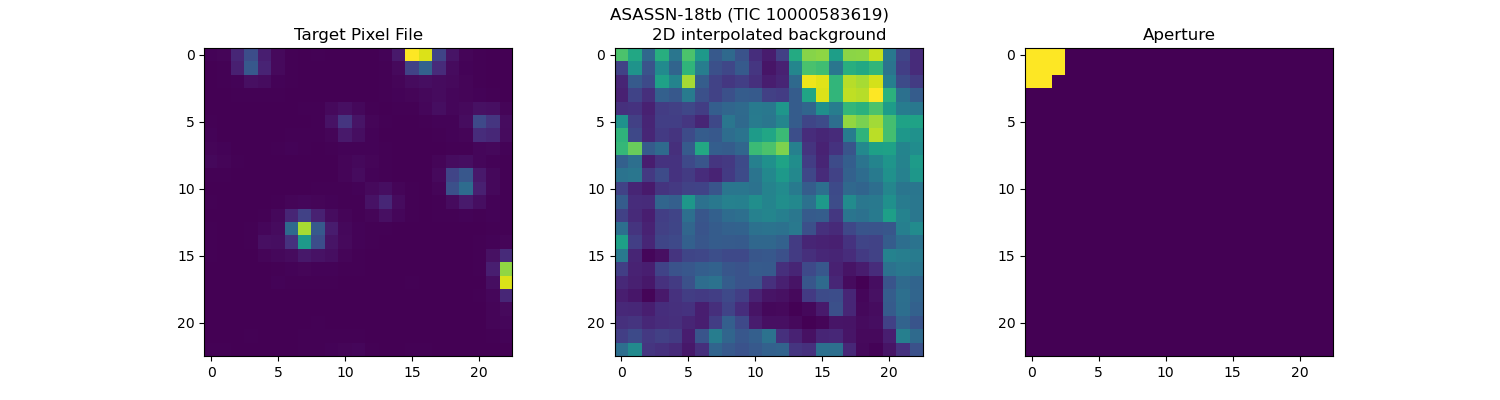

<IPython.core.display.Javascript object>


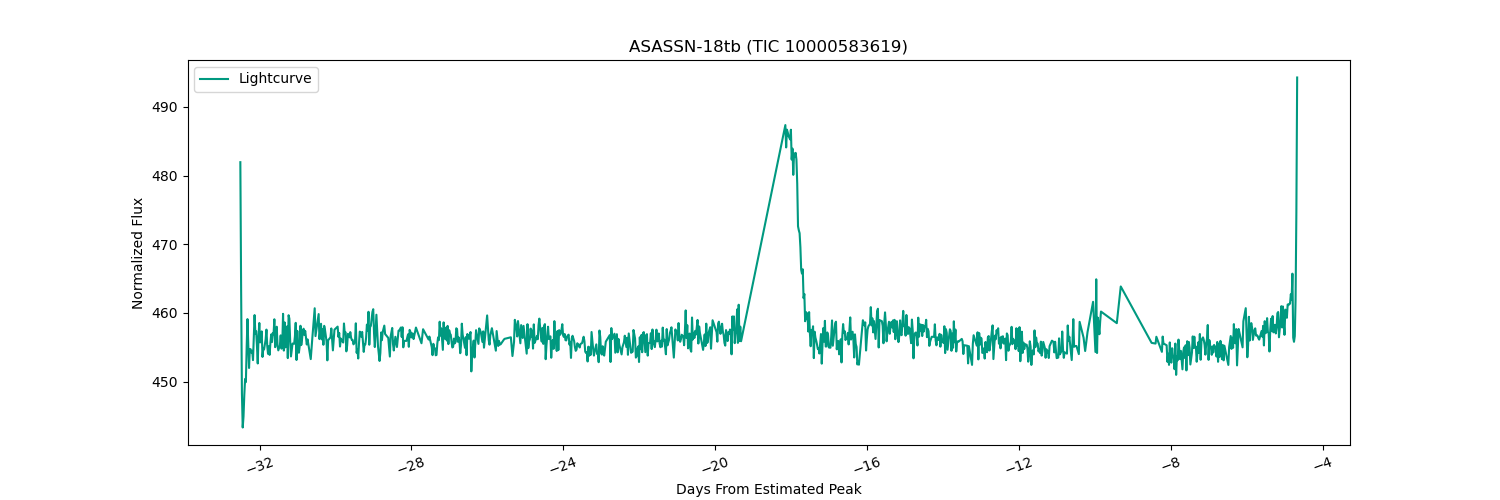

In [25]:
asassn = snStats(radec='04 18 06.149 −63 36 56.68', sector=1, tpfSize=23, peak='2018-08-27 07:55:12.000',
        plot=True,targetName='ASASSN-18tb',verbose=True)
#asassn[1].to_pandas() 

The following few cells go through the lightcurve correction tutorial shown in the documentation for lightkurve found here: https://docs.lightkurve.org/tutorials/04-how-to-remove-tess-scattered-light-using-regressioncorrector.html

In [7]:
# targ = SkyCoord('04 18 06.149 −63 36 56.68',unit=(u.hourangle,u.deg));
# tpf = lk.search_tesscut(targ,sector=1).download(cutout_size=(31,31))
# aper = tpf.create_threshold_mask()
# raw_lc = tpf.to_lightcurve(aperture_mask=aper)
# raw_lc.plot()
# regressors = tpf.flux[:, ~aper]
# plt.plot(regressors[:, :30]);
# plt.show()

# dm = lk.DesignMatrix(regressors, name='regressors')
# dm = dm.pca(5)
# plt.plot(tpf.time, dm.values + np.arange(5)*0.2, '.');
# plt.show()

# dm = dm.append_constant()
# corrector = lk.RegressionCorrector(raw_lc)
# corrected_lc = corrector.correct(dm)
# ax = raw_lc.plot(label='Raw light curve')
# corrected_lc.plot(ax=ax, label='Corrected light curve');
# plt.show()

# corrector.diagnose();
# model = corrector.model_lc
# model -= np.percentile(model.flux, 5)
# model.plot();
# plt.show()

In [8]:
# corrected_lc = raw_lc - model
# #ax = raw_lc.plot(label='Raw light curve',normalize=True)
# ax = corrected_lc.scatter( label='Corrected light curve',normalize=False);

In [9]:
# bkg = np.median(regressors, axis=1)
# bkg -= np.percentile(bkg, 5)

# npix = aper.sum()
# median_subtracted_lc = raw_lc - npix * bkg

# ax = median_subtracted_lc.plot(label='Median background subtraction',normalize=False)
# corrected_lc.plot(ax=ax, label='RegressionCorrector',normalize=False);

Attempting to find flux data for the nearby stars used to remove systematics from supernova lightcurve in [Vallely et al.](https://arxiv.org/abs/1903.08665) (see Section 3 and Figure 3 for further details about the two stars)

In [37]:
gaiaID1 = 4676041915767041280
gaiaID2 = 4676043427595528448
s1 = eleanor.Source(gaia=gaiaID1,sector=1);
print("star 1 (Gaia ID"+str(gaiaID1)+") TESS Magnitude: "+str(s1.tess_mag)+" mag")
print("Paper reports star 1 TESS Magnitude as 12.3438 ± 0.0005 mag") ## Seems to be a difference of about ~0.49%
s2 = eleanor.Source(gaia=gaiaID2,sector=1);
print("star 2 (Gaia ID"+str(gaiaID2)+") TESS Magnitude: "+str(s2.tess_mag)+" mag")
print("Paper reports star 2 TESS Magnitude as 13.653 ± 0.001 mag") ## Seems to be a difference of about ~0.44%
## So TESS magnitudes of both are roughly what's expected according to paper, values differ by roughly same percent 

d1 = eleanor.TargetData(s1,height=23,width=23);
d2 = eleanor.TargetData(s2,height=23,width=23);

INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
star 1 (Gaia ID4676041915767041280) TESS Magnitude: 12.4049 mag
Paper reports star 1 TESS Magnitude as 12.3438 ± 0.0005 mag
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_e

The two TPFs seem to be the same as each other as well as the supernova above. More concerningly, the aperture for all three seems to be the same, centered at the upper left hand corner (0,0). Eleanor is supposed to automatically find the best aperture for each target

<IPython.core.display.Javascript object>


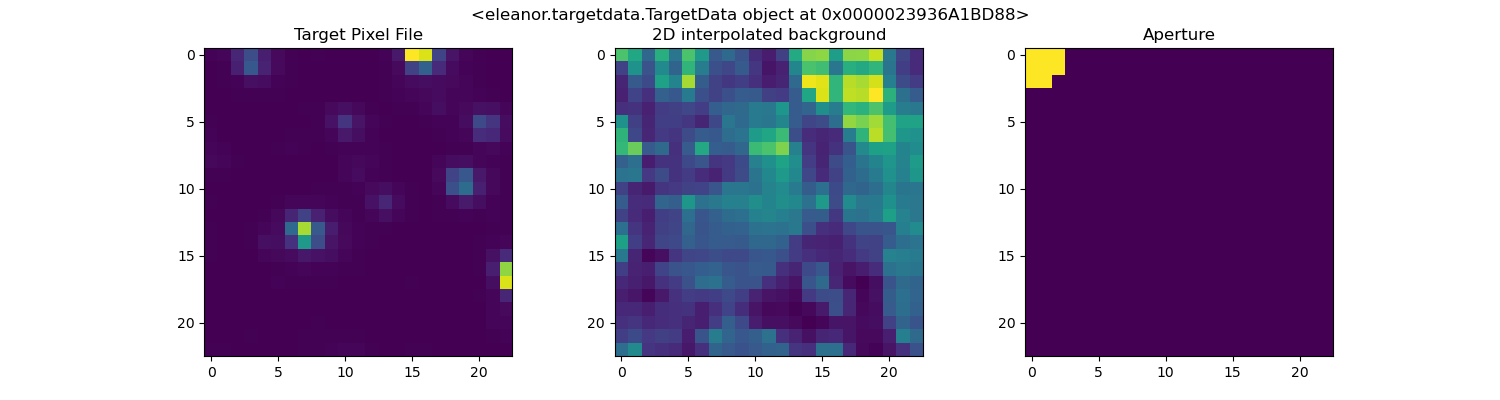

<IPython.core.display.Javascript object>


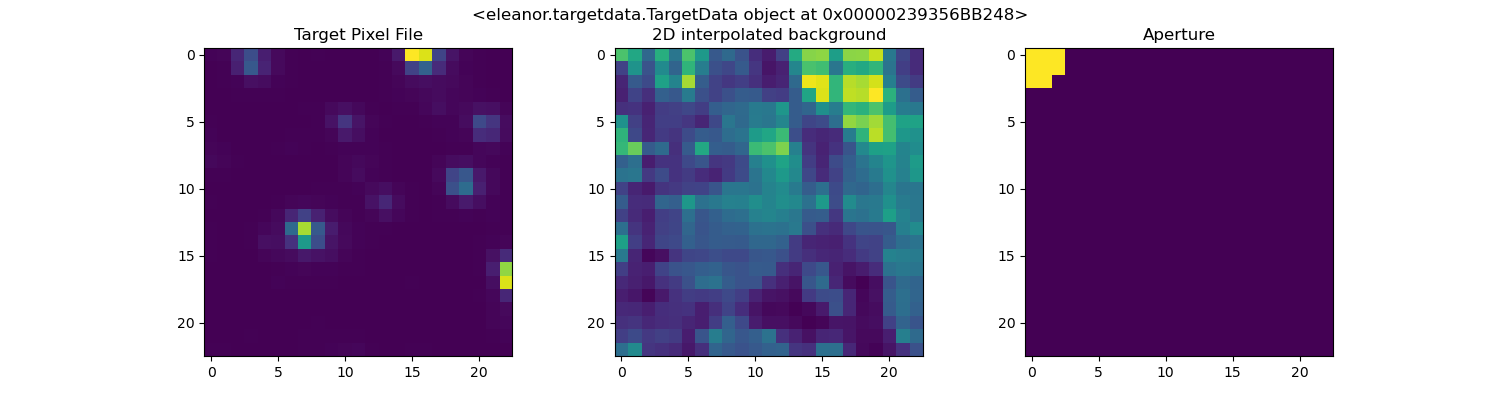

In [38]:
## Plotting the TPFs of the two stars
for star in [d1,d2]:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
    ax1.imshow(star.tpf[0])
    ax1.set_title('Target Pixel File')
    ax2.imshow(star.bkg_tpf[0])
    ax2.set_title('2D interpolated background')
    ax3.imshow(star.aperture)
    ax3.set_title('Aperture')
    fig.suptitle(str(star))
    plt.show()

There's no easily discernible difference between the two lightcurves

<IPython.core.display.Javascript object>


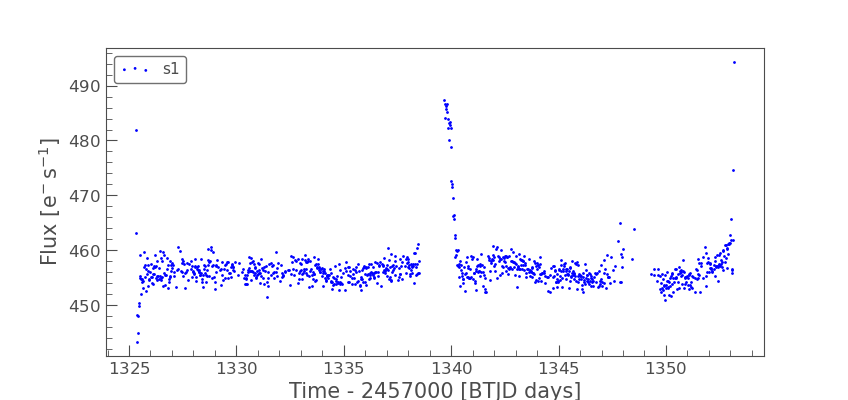

<IPython.core.display.Javascript object>


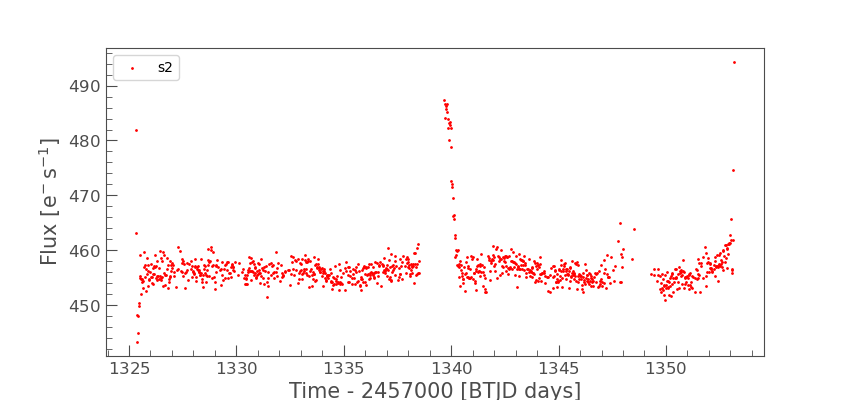

In [39]:
## Converts the eleanor TargetData objects to lightkurve objects and plots them
d1k = d1.to_lightkurve()
d2k = d2.to_lightkurve()
d1k.scatter(normalize=False,color='blue',label='s1')
d2k.scatter(normalize=False,color='red',label='s2')
plt.legend()

while the two stars seem to have almost identical lighcurves, the actual flux values are not sampled at the same times and are not the same magnitude

number of matching time values: 0
number of matching flux values: 0


<IPython.core.display.Javascript object>


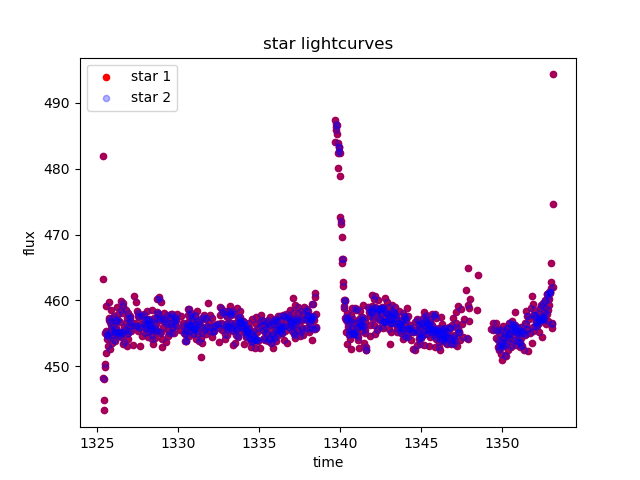

In [65]:
## converts lightkurve objects to pandas DataFrames
d1p=d1k.to_pandas()
d2p=d2k.to_pandas()

# t1 = d1p['flux']
# t2 = d2p['flux']
# t3 = [1 if t1[datum] == t2[datum] else 0 for datum in range(len(t1)) ]
# print(sum(t3))
sameTimes = np.count_nonzero(d1p['time'].to_numpy()==d2p['time'].to_numpy())
sameFluxes = np.count_nonzero(d1p['flux'].to_numpy()==d2p['flux'].to_numpy())
print('number of matching time values: '+str(sameTimes))
print('number of matching flux values: '+str(sameFluxes))
#display_side_by_side(d1p,d2p)

ax = d1p.plot(x='time',y='flux',color='red',label='star 1',kind='scatter')
d2p.plot(x='time',y='flux',color='blue',label='star 2',alpha=0.3, kind='scatter',ax=ax)
plt.legend()
plt.title('star lightcurves')
plt.show()

In [16]:
## retreiving ASASSN-18tb eleanor data
source = eleanor.Source(coords=SkyCoord('04 18 06.149 −63 36 56.68',
                                    unit=(u.hourangle,u.deg)),sector=1)
data = eleanor.TargetData(source,height=23,width=23,
                         do_psf=False,do_pca=False)

INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file C:\Users\Tyler\.eleanor/mastDownload\HLSP\hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc\hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]


Vallely et al. subtracts the the average of the two stars' lightcurves from the lightcurve of the supernova (see Figure 3). While this is flux rather than counts, one would expect that averaged flux would be roughly half that of the supernova flux, but one can see that the flux values are almost the same. Inspecting the data shows that the fluxes only differ by about E-3 electrons per second at most, which is significantly different from what is expected.

<IPython.core.display.Javascript object>


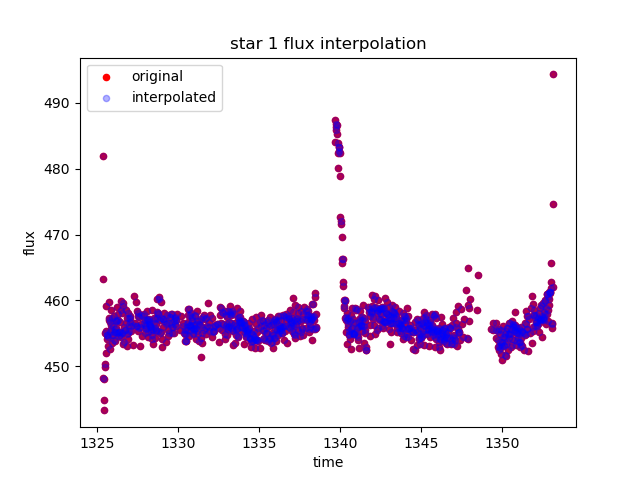

<IPython.core.display.Javascript object>


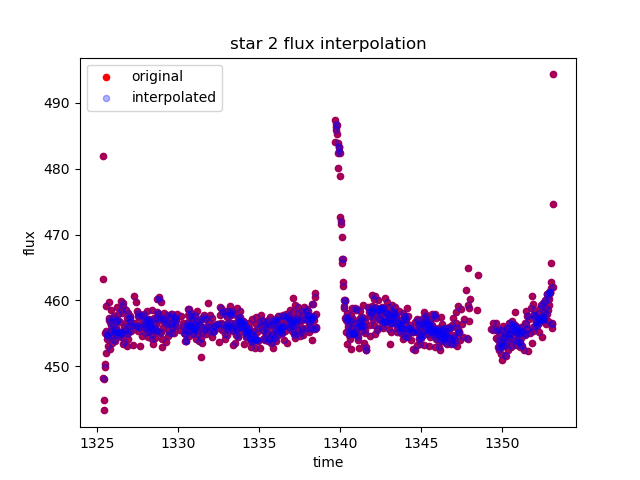

In [56]:
snp = data.to_lightkurve().to_pandas()
#display_side_by_side(d1p, interpToData(d1p,d2p)[1])
snp, d1pInterp, d2pInterp = interpToData(snp,d1p,d2p)
#display(d1pInterp)
starNum = 1
for item in [[d1p,d1pInterp],[d2p,d2pInterp]]:
    ax = item[0].plot(x='time',y='flux',color='red',label='original',kind='scatter')
    item[1].plot(x='time',y='flux',color='blue',label='interpolated',alpha=0.3,kind='scatter',ax=ax)
    plt.title('star '+str(starNum)+' flux interpolation')
    plt.legend()
    plt.show()
    starNum +=1

<IPython.core.display.Javascript object>


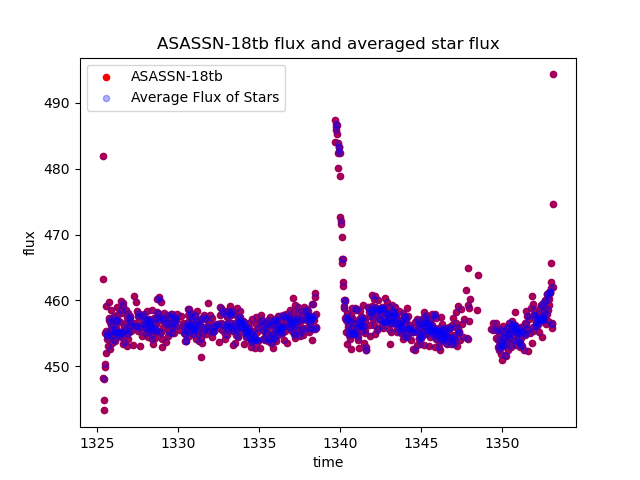

In [68]:
## Finding average of two stars as outlined in Vallely et al.
avgFlux = pd.DataFrame(index=snp.index)
avgFlux['time'] = 0.5 * (d1pInterp['time'] + d2pInterp['time'])
avgFlux['flux'] = 0.5 * (d1pInterp['flux'] + d2pInterp['flux']) 
avgFlux['flux_err'] = 0.5 * (d1pInterp['flux_err'] + d2pInterp['flux_err']) 

ax = snp.plot(x='time',y='flux',color='red',label='ASASSN-18tb',kind='scatter')
avgFlux.plot(x='time',y='flux',color='blue',label='Average Flux of Stars',alpha=0.3,kind='scatter',ax=ax)
plt.title('ASASSN-18tb flux and averaged star flux')
plt.legend()
plt.show()
#display_side_by_side(snp,avgFlux)

Eleanor continues to identify the aperture as being centered in the upper left hand corner. I attempted to adapt some code from Eleanor's documentation about manually specifying the aperture, but I am still investigating this.

<IPython.core.display.Javascript object>


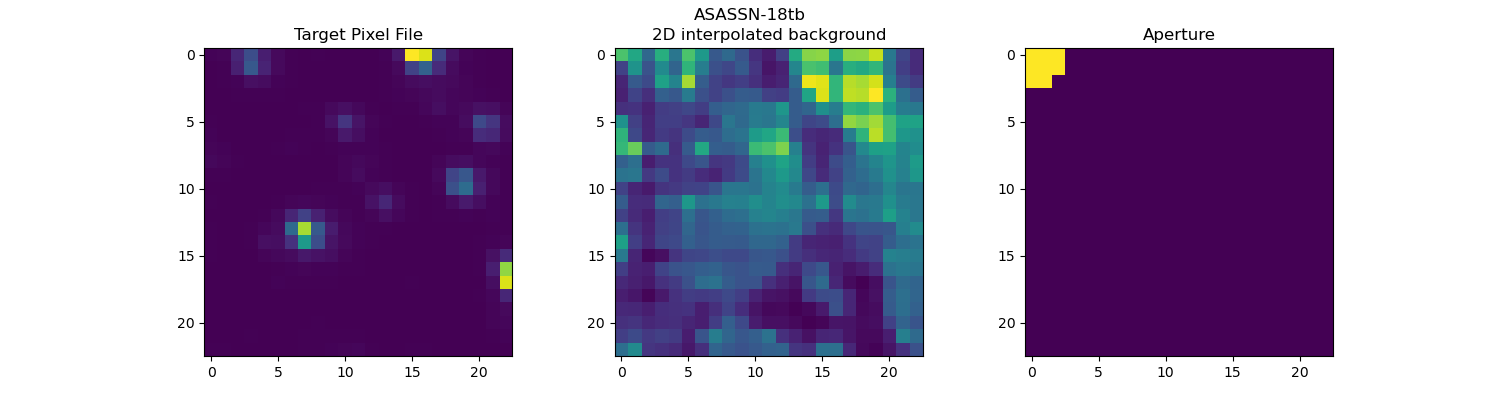

<IPython.core.display.Javascript object>


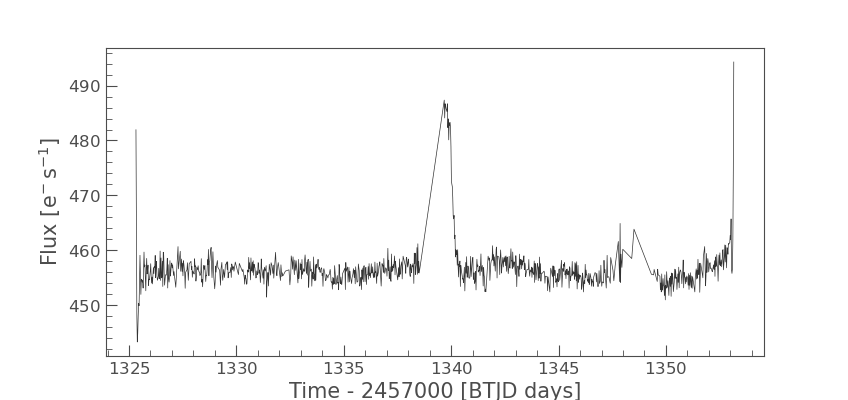

In [71]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');
ax3.imshow(data.aperture)
ax3.set_title('Aperture');
fig.suptitle('ASASSN-18tb')
plt.show()
data.to_lightkurve().plot()

<IPython.core.display.Javascript object>


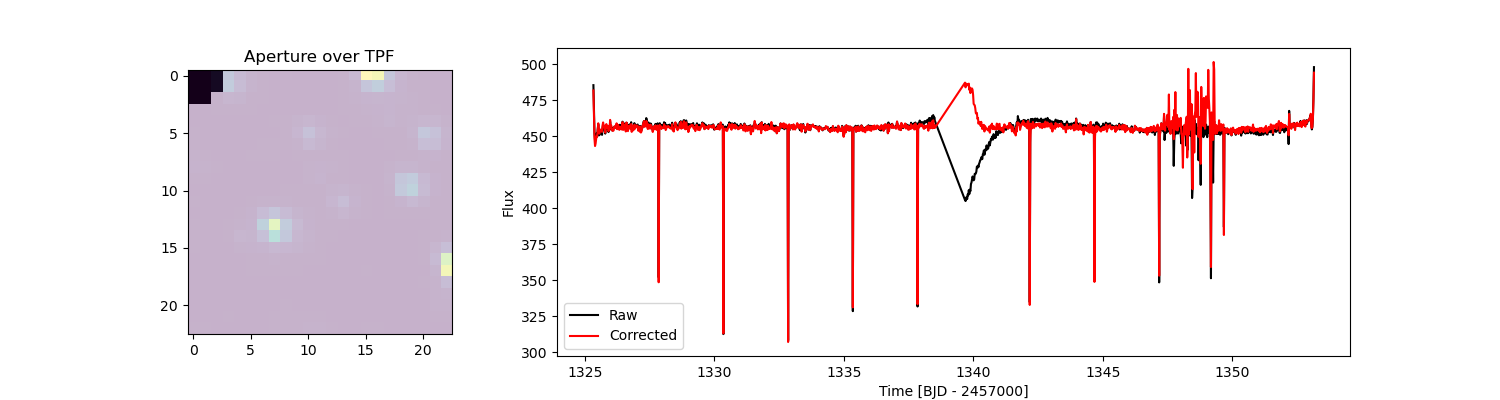

In [24]:
#eleanor.TargetData.custom_aperture(data, shape='circle', r=1, pos=[11,11], method='exact')
#eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.all_apertures[0], cmap='Greys', alpha=0.7)
ax1.set_title('Aperture over TPF')

ax2.plot(data.time, data.raw_flux, 'k', label='Raw')
ax2.plot(data.time, data.corr_flux, 'r', label='Corrected')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Flux')
ax2.legend();

Eleanor's visualization tools demonstrate odd behavior (I made the latter plot in an attempt to replicate a version of Figure 5 from Vallely et al. but have yet to succeed)

<IPython.core.display.Javascript object>


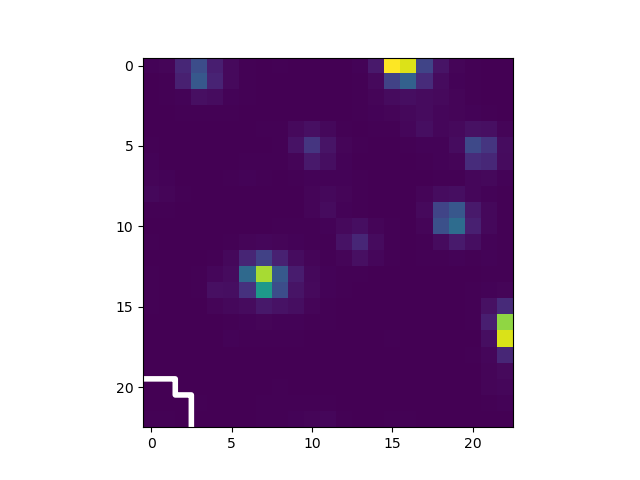

<IPython.core.display.Javascript object>


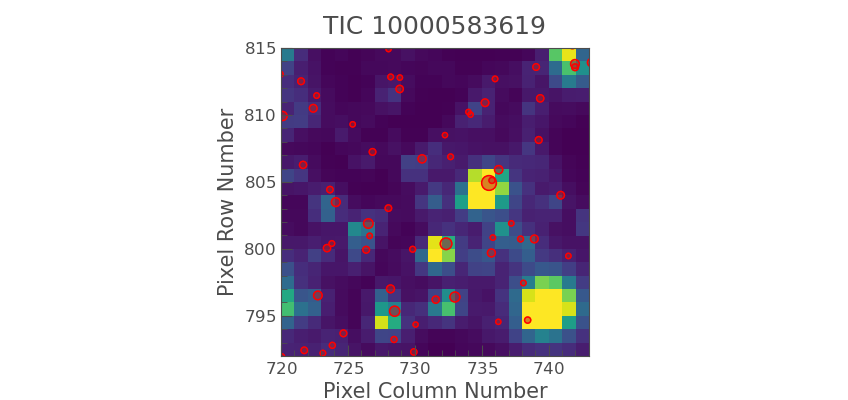

<IPython.core.display.Javascript object>


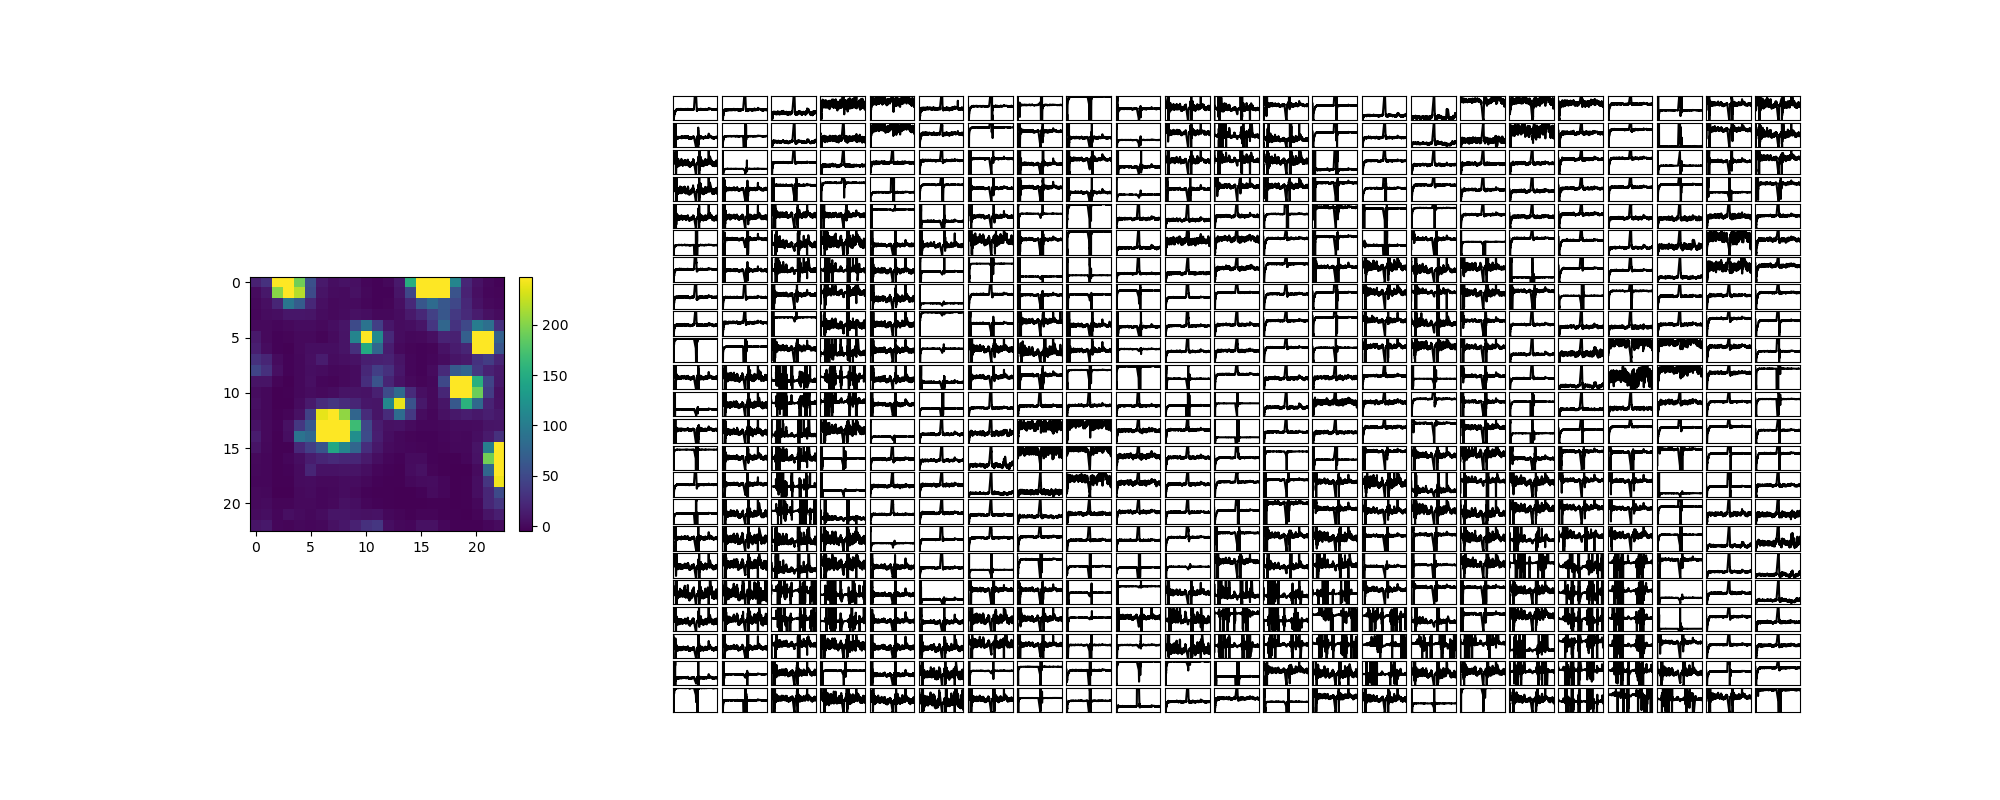

In [77]:
vis = eleanor.Visualize(data)
vis.aperture_contour()
fig_gaia = vis.plot_gaia_overlay(magnitude_limit=19)
fig = vis.pixel_by_pixel()